In [1]:
import torch
from torch import nn
from torch.utils.data import dataset
import importlib
import sys
sys.path.append("../")
import ES.ES_classes
import ES.ES_NeuralGraph
importlib.reload(ES.ES_classes)
importlib.reload(ES.ES_NeuralGraph)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Randomly generate n-digit addition problems with consisten length
stoi = {str(i):i for i in range(2)}
stoi["+"] = len(stoi)
stoi["="] = len(stoi)
stoi[","] = len(stoi)
itos = {v:k for k, v in stoi.items()}

vocab_size = len(stoi)

def get_batch(batch_size, examples, n=3):
    num1s = np.random.randint(2**n, size=(batch_size, examples))
    num2s = np.random.randint(2**n, size=(batch_size, examples))

    strings = ["".join([f"{bin(num1)[2:].zfill(n)}+{bin(num2)[2:].zfill(n)}={bin(num1+num2)[2:].zfill(n+1)}," for num1, num2 in zip(num1s[batch], num2s[batch])]) for batch in range(batch_size)]
    # print(strings)
    ids = torch.Tensor([[stoi[c] for c in string] for string in strings]).to(device).long()

    x_batch = ids[:, :-1]
    y_batch = ids[:, 1:]

    return x_batch, y_batch

In [116]:
x_batch, y_batch = get_batch(16, 8)

print(x_batch.shape, y_batch.shape)

torch.Size([16, 103]) torch.Size([16, 103])


In [117]:
# Shuffles up which tokens map to which indices cuz I'm evil and want to torture the ngraph >:)
def shuffle_lang(x_batch, y_batch):
    batch_size = x_batch.shape[0]

    reordering = torch.stack([torch.randperm(vocab_size) for _ in range(batch_size)]).to(device)

    x_batch = torch.stack([reordering[i][x_batch[i]] for i in range(batch_size)])
    y_batch = torch.stack([reordering[i][y_batch[i]] for i in range(batch_size)])
    return x_batch, y_batch, reordering

In [118]:
ch_n = 8
ch_e = 8
ch_n_const = 2 # Flag for inp and out node

In [119]:
n_inp = vocab_size
n_hid = 32
n_out = vocab_size

n_nodes = n_inp + n_hid + n_out

connections = [[i, j] for i in range(n_inp) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp + n_hid, n_inp + n_hid + n_out)]

connections = torch.Tensor(connections)

print(connections.shape)

graph = ES.ES_NeuralGraph.NeuralGraph(n_nodes, n_inp, n_out, connections,
    ch_n=ch_n, ch_e=ch_e, ch_n_const=2, init_mode="trainable", init_std=.01, set_nodes=True, use_label=True,
    aggregation="mean", clamp_mode="hard", max_value=100).to(device)# inp_enc=inp_enc, out_dec=out_dec

optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='none')
sigma = .05

log = []

torch.Size([1344, 2])


In [120]:
for i, rule in enumerate(graph.ruleset):
    rule.load_state_dict(torch.load(f"arithmetic_model_{i}.pt"))

In [121]:
const_n=torch.zeros(n_nodes, 2).to(device)
const_n[:n_inp, 0] = 1
const_n[-n_out:, 1] = 1
graph.set_const_vals(const_n)

In [125]:
steps = 100_000
T = 5
DT = 1
batch_size = 256
n = 2
example_len = 3*n+4
examples = 10
answer_indices = torch.cat([torch.range(start+7, start+10) for start in range(0, example_len*examples, example_len)]).long()

with torch.no_grad():

    bar = tqdm(range(1, steps+1))
    for step in bar:
            x_batch, y_batch = get_batch(batch_size, examples=examples, n=n)
            shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

            graph.generate_epsilons(batch_size, sigma=sigma)
            graph.init_vals(nodes=True, edges=True, batch_size=batch_size)

            preds = []
            for t in range(x_batch.shape[1]):
                # Unsqueeze to represent only one input node
                pred = graph.forward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), T, DT, edges=False)
                graph.backward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), nn.functional.one_hot(shuffled_y[:, t], vocab_size), T, DT, edges=False, edges_at_end=True)

                preds.append(pred)

            preds = torch.stack(preds, axis=1)

            # Acc kinda want to make sure it learns the numbers
            # Only "grade" the answers and 
            # preds = [:, answer_indices]


            # For some reason batch dims can be dim 0 and dims 2, 3, ...  NOT DIM 1
            losses = criterion(torch.swapaxes(preds, -1, -2), shuffled_y).mean(-1)
            loss = losses.mean().item()

            accs = (preds.argmax(-1) == shuffled_y).float().mean(-1)
            acc = accs.mean().item()

            overflows = torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1) + torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1)
            overflow = overflows.mean().item()

            graph.estimate_grads(losses - accs + overflows, sigma=sigma, normalize=True) 
            optimizer.step()

            entry = {'loss':loss, 'acc':acc, 'overflow':overflow}
            log.append(entry)
            bar.set_postfix(entry)

C:\Users\bunna\AppData\Local\Temp\ipykernel_31204\3921871572.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  answer_indices = torch.cat([torch.range(start+7, start+10) for start in range(0, example_len*examples, example_len)]).long()
  0%|          | 0/100000 [00:00<?, ?it/s]

  2%|▏         | 1517/100000 [1:07:04<72:33:58,  2.65s/it, loss=0.567, acc=0.682, overflow=0.00321] 


KeyboardInterrupt: 

In [126]:
print(preds[:, 13::example_len, :].shape)
print(y_batch[0, 11::example_len])
print("".join([itos[i.item()] for i in y_batch[0].cpu()])) # [10::example_len]

TypeError: list indices must be integers or slices, not tuple

In [131]:
torch.save(graph.state_dict(), "arithmetic_model.pt")

for i, rule in enumerate(graph.ruleset):
    torch.save(rule.state_dict(), f"arithmetic_model_{i}.pt")

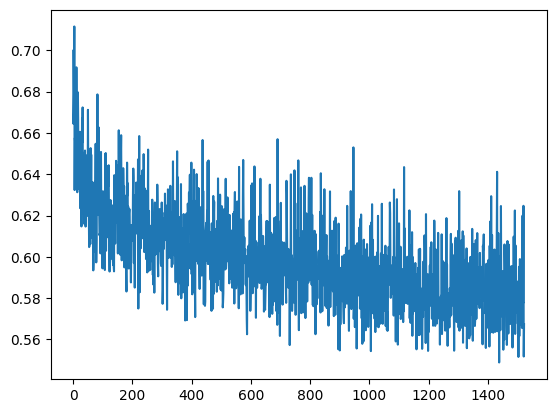

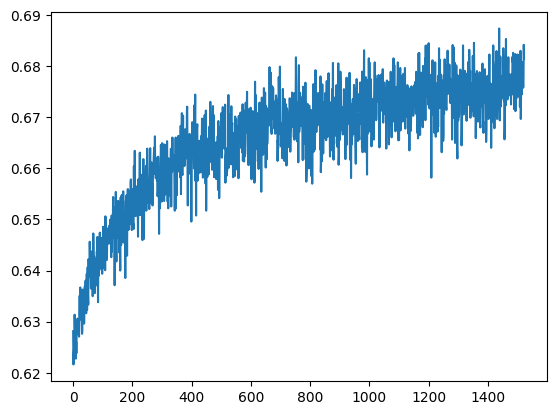

In [127]:
plt.plot([e["loss"] for e in log])
plt.show()
plt.plot([e["acc"] for e in log])
plt.show()

In [129]:
test_batch_size = 2048

with torch.no_grad():
    x_batch, y_batch = get_batch(test_batch_size, examples=examples, n=n)
    shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

    graph.generate_epsilons(test_batch_size, sigma=sigma)
    graph.init_vals(nodes=True, edges=True, batch_size=test_batch_size)

    preds = []
    for t in range(shuffled_x.shape[1]):
        # Unsqueeze to represent only one input node
        pred = graph.forward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), T, DT, edges=False)
        graph.backward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), nn.functional.one_hot(shuffled_y[:, t], vocab_size), T, DT, edges=False, edges_at_end=True)

        preds.append(pred)

    preds = torch.stack(preds, axis=1)

    accs = (preds.argmax(-1) == shuffled_y).float().mean(0).cpu().numpy()

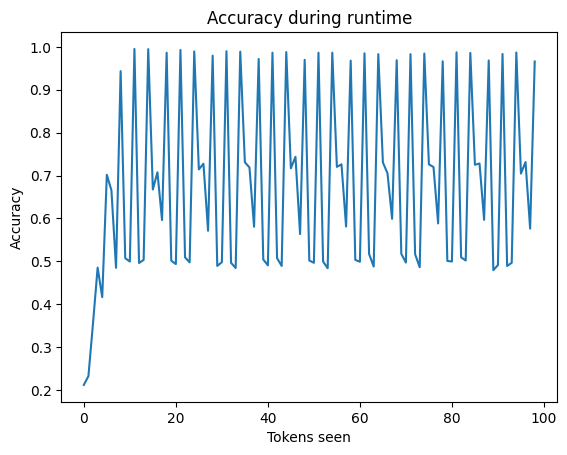

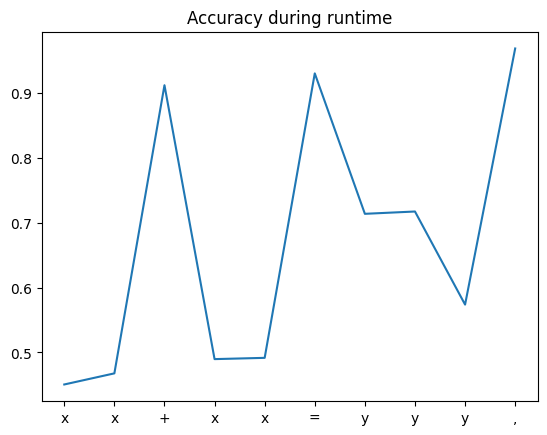

In [130]:
plt.plot(accs)
plt.title("Accuracy during runtime")
plt.xlabel("Tokens seen")
plt.ylabel("Accuracy")
plt.show()

format = "xx+xx=yyy,"

plt.plot(np.mean(np.concatenate([[0], accs]).reshape(examples, example_len), axis=0))
plt.title("Accuracy during runtime")
plt.xticks(np.arange(len(format)), [c for c in format])
plt.show()

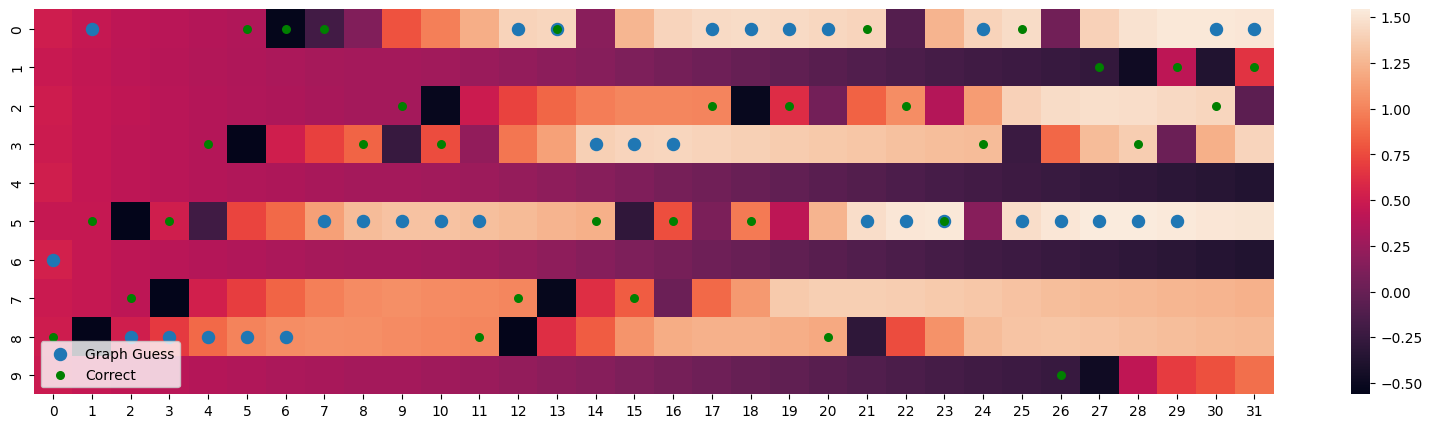

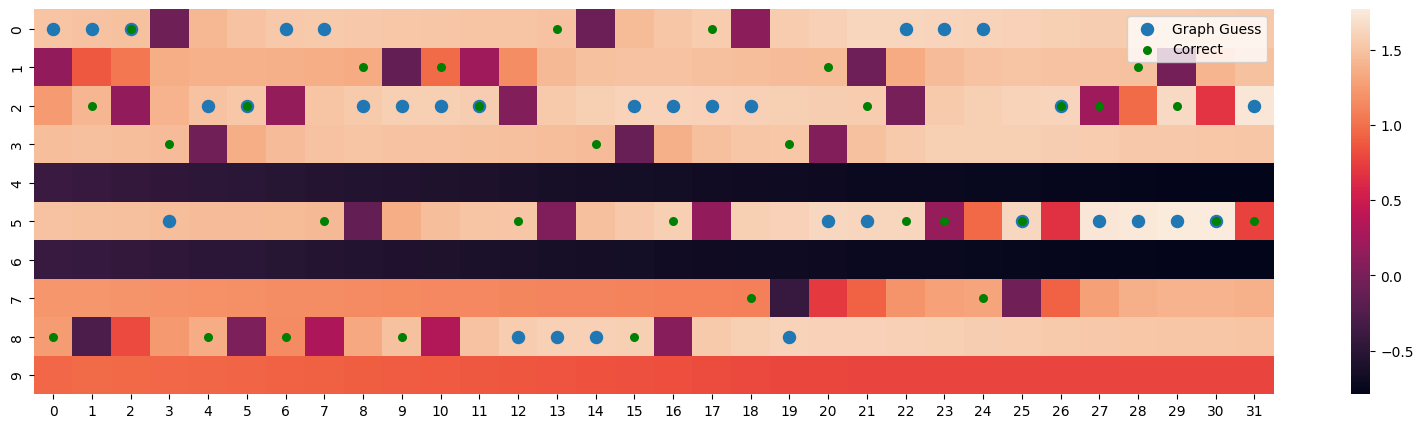

In [82]:

i = 1

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, :32].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, :32].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, :32].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, 32:].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, 32:].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, 32:].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

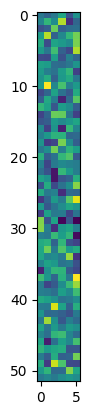

In [67]:
# plt.imshow(graph.init_edges.cpu().detach())
plt.imshow(graph.init_nodes.cpu().detach())

In [47]:
print(graph.init_nodes.shape)
print(graph.const_n.shape)

torch.Size([16, 14])
torch.Size([16, 2])


In [38]:
num_batches = train_data.shape[1] // bptt
print(num_batches)

15


In [37]:
print(train_data.shape)

torch.Size([512, 4003])
